# SMYLE: NH Ice Extent Check 
 - Check NH seasonal sea ice prediction, compare to DPLE
 - data I/O functions based on ENSO_check.ipynb

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [26]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) #adapt(minimum_jobs=0, maximum_jobs=24)

In [4]:
cluster

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are currently hard-wired to retrieve ocean monthly data

In [5]:
def file_dict(filetempl,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given experiment, field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    filetemp = filetempl.replace('MM',monstr).replace('EEE',memstr)

    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split('.pop.h.')[0]
        y0 = int(ystr[-11:-7])
        filepaths[y0]=file
        
    return filepaths

In [6]:
def nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(filetemplate,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [9]:
## NOTE
## Regulate dask array size using this proprocess function.
## Set appropriately based on analysis to come.
## E.g., currently set to extract only first 24 months of data
def preprocess(ds):
    return ds.isel(time=slice(0,24))

def open_members(in_obj):
    ffs = in_obj[0]  #unwrap the list
    field = in_obj[1]
    ens = in_obj[2]
    lm = in_obj[3]
    chunks = in_obj[4]
    
    d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,concat_dim='M',data_vars=[field],\
                           chunks=chunks,compat='override', coords='minimal', preprocess=preprocess)
    #added compat=override, coords=minimal here. Assumes that all hindcasts have same dims/coords. Seems a little dangerous
    #but REALLY speeds things up. And we know that the coords are the same for all of SMYLE anyway.

    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    # quick fix to compute seasonal means -- DOESN'T WORK!
    #month_length = d0.time.dt.days_in_month
    #d0 = ((d0 * month_length).resample(time='QS-JAN').sum() /
    #      month_length.resample(time='QS-JAN').sum())
    d0 = d0.assign_coords(M=("M",ens))
    d0 = d0.assign_coords(L=("time",lm))
    d0 = d0.swap_dims({'time': 'L'})
    d0 = d0.reset_coords(["time"])
    
    return d0

In [10]:
def get_monthly_data(filetemplate,ens,leads,field,firstyear,lastyear,stmon,chunks={}):
    ''' returns dask array containing the requested hindcast ensemble '''

    ds = xr.Dataset()    #instantiate Dataset
    lm = np.array(leads)+1
    files,yrs = nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon)
    ens = np.array(ens)+1
    
    # all members should have the same number of files, otherwise abort
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        complete_set=True   # same number of files
    else:
        raise ValueError('ERROR: Incomplete set of files')
        
    if complete_set: #read all data using map/gather
        dsets = []
        in_obj = [[ffs, field, ens, lm, chunks] for ffs in files]
        dsets = client.map(open_members, in_obj)
        dsets = client.gather(dsets)
        tmp = xr.concat(dsets,dim='Y',data_vars=[field,'time','time_bound'], coords='minimal', compat='override')
        #potentially dangerous compat/coords option - xarray is NOT checking that the coordinates 
        #are the same across all files - pulling values of shared coords from the first file only
        #speeds up read-in time by ~1/3
        tmp = tmp.assign_coords(Y=("Y",yrs))

    ds[field] = tmp[field]
    ds['time'] = tmp['time']
    ds['time_bound'] = tmp['time_bound']
    ds['TAREA'] = tmp['TAREA']
    ds['UAREA'] = tmp['UAREA']

    return ds

# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [11]:
%%time
# SMYLE data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'IFRAC'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(20) 
leadtimes = range(24)
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':120}
smyle_ifrac = get_monthly_data(filetemplate,ens,leadtimes,field,firstyear,lastyear,startmonth)
smyle_ifrac.nbytes/1e9 #GB

CPU times: user 19.5 s, sys: 11.9 s, total: 31.5 s
Wall time: 35.7 s


11.566477608

In [12]:
# Full array can fit in distributed memory, so call persist
smyle_ifrac = smyle_ifrac.persist()

In [13]:
%%time
# DPLE data
# process all 40 ensemble members, all November start dates from 1970-2018:
field = 'IFRAC'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
#leadtimes = range(122)
leadtimes = range(24)
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
dple_ifrac = get_monthly_data(filetemplate,ens,leadtimes,field,firstyear,lastyear,startmonth)
dple_ifrac.nbytes/1e9 #GB

CPU times: user 10.8 s, sys: 2.64 s, total: 13.4 s
Wall time: 18.9 s


22.655168384

In [14]:
# Full array can fit in distributed memory, so call persist
dple_ifrac = dple_ifrac.persist()

### Compute NH Ice Extent

In [15]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA/(100.**2)/(1000.**2)
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [17]:
POPg16_arctic_area = POP_regional_areawgt(smyle_ifrac,[-180.,180.],[40.,82.])

- Here, perform actual computation, returning xarray

In [18]:
%%time
smyle_nhice = (smyle_ifrac.IFRAC*POPg16_arctic_area).sum(("nlon", "nlat")).load()
smyle_time_bound = smyle_ifrac.time_bound.load()

CPU times: user 2.46 s, sys: 58.6 ms, total: 2.52 s
Wall time: 2.64 s


In [19]:
%%time
dple_nhice = (dple_ifrac.IFRAC.isel(L=slice(0,24))*POPg16_arctic_area).sum(("nlon", "nlat")).load()
dple_time_bound = dple_ifrac.time_bound.load()

CPU times: user 5.28 s, sys: 106 ms, total: 5.39 s
Wall time: 5.65 s


In [21]:
# Observed SIE (SSMI nsidc-0051)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/seaice/SSMI/nsidc-0051/nt_1979_01-2017_12.monthly.NH.nc',decode_times=False)
ds_obs['time'] = [cftime.DatetimeNoLeap(1979+year, 1+month, 15) for year in range(39) for month in range(12)]
region1 = (ds_obs.lat>=40) & (ds_obs.lat<=82)
areawgt1 = xr.where(region1, ds_obs.area.fillna(0),0)
obs_nhice = (ds_obs.ifrac*areawgt1).sum(("nlon", "nlat")).load()

### Compute seasonal-average Time Series

In [22]:
def jfm_mean(ds):
    month_length = ds.time.dt.days_in_month
    result = ((ds * month_length).resample(time='QS-JAN').sum() /
          month_length.resample(time='QS-JAN').sum())
    return result.sel(time=result['time.month']==1)
def jas_mean(ds):
    month_length = ds.time.dt.days_in_month
    result = ((ds * month_length).resample(time='QS-JAN').sum() /
          month_length.resample(time='QS-JAN').sum())
    return result.sel(time=result['time.month']==7)

In [23]:
obs_nhice_jfm = jfm_mean(obs_nhice)
obs_nhice_jas = jas_mean(obs_nhice)

### Generate Time Series Plot

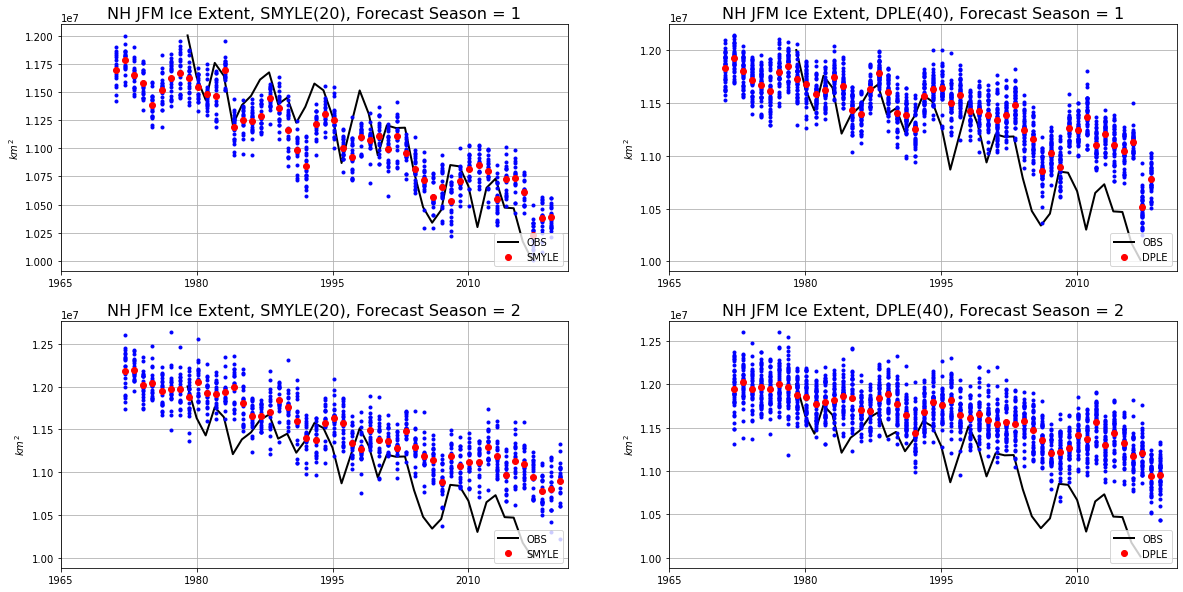

In [24]:
nlead = 2
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

# JFM1
lrange = [3,4,5]
smyletime = smyle_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+1)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='SMYLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, SMYLE(20), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')
    
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+2)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, DPLE(40), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

lrange = [15,16,17]
smyletime = smyle_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+1)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='SMYLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, SMYLE(20), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')
    
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+2)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, DPLE(40), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

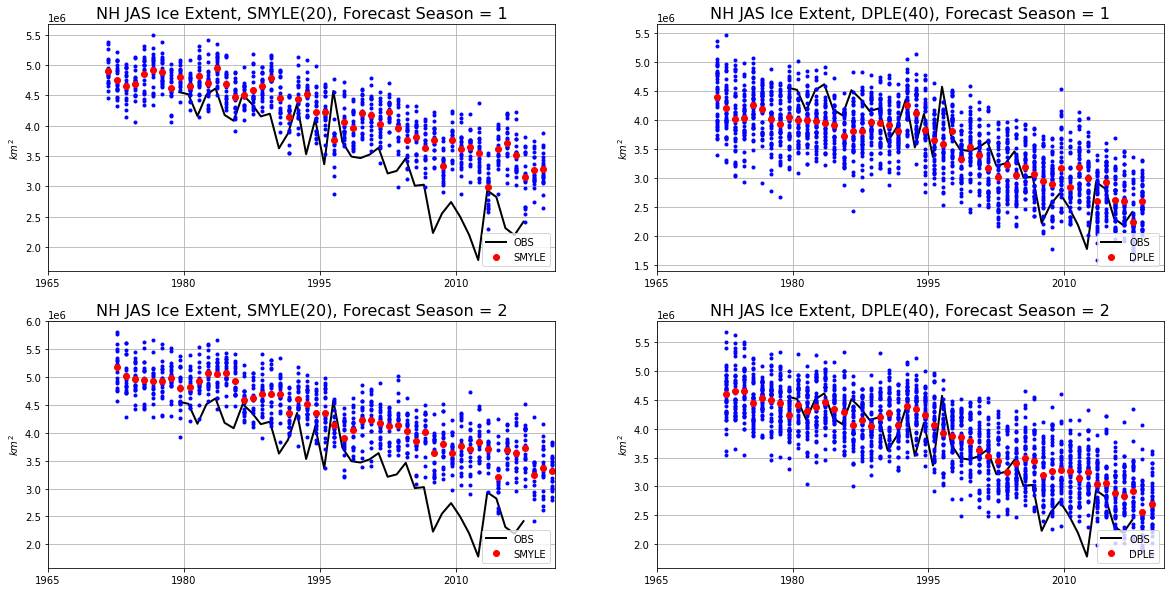

In [25]:
nlead = 2
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

# JFM1
lrange = [9,10,11]
smyletime = smyle_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+1)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='SMYLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, SMYLE(20), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')
    
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+2)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, DPLE(40), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

lrange = [21,22,23]
smyletime = smyle_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+1)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(smyletime,smyle_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='SMYLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, SMYLE(20), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')
    
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+2)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, DPLE(40), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')